<a href="https://colab.research.google.com/github/pmanoonpong/Imageprocessing/blob/main/Copy_of_EX2_Finetune_Detect_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EX2 Object detection and Segmentation with Mask-RCNN

ในตัวอย่างนี้เราจะทำการ Finetuning โดยใช้หลักการ Transfer learning บนโมเดล MASK-RCNN ที่ได้ถูกเทรน Weight เบื้องต้นมาแล้ว โดยเราจะทำการ Finetuning โดยการแทนที่ output neural ด้วยจำนวน class ที่เราต้องการทำนาย
จากนั้นให้ระบบเรียนรู้ Weight ใหม่โดยอาศัยข้อมูลจาก Penn-Fudan Dataset  เพื่อให้ระบบเรามีพฤติกรรมการ Predict ที่เปลี่ยนแปลงไปสอดคล้องกับ Dataset ใหม่


**ในตัวอย่างนี้จะแบ่งเป็น 4 Section ดังนี้**

1. เตรียมและทำความเข้าใจ Environment, Dataset

2. Finetuning on existing model
ในตัวอย่างนี้เราจะใช้โมเดล Mask R-CNN ที่ได้ทำการถูกเทรนค่า weight เบื้องต้นมาทำการ Fine-tuning ด้วยการใช้ Penn-Fudan Database ซึ่งเป็น Database ที่เป็นคู่ข้อมูลระหว่าง ภาพ - masks ซึ่งระบุตำแหน่งที่คนอยู่บนภาพ

3. Object detection
นำข้อมูลที่ได้จากการ Predict ผ่านโมเดลที่ถูก Finetuning แล้วมาแสดงผลในรูปแบบ Object detection

4. Object segmentation
นำ Masks ผลลัพธ์ที่ได้จากการ Predict ผ่านโมเดลที่ถูก Finetuning แล้วมาแสดงผลในรูปแบบ Instance segmentation





#Section ที่ 1 : เตรียมและทำความเข้าใจ Environment, Dataset

**1.1 Install compiler pycocotools ลงบน GoogleColab**

**1.2 โหลดฐานข้อมูล PennFudanPed ลงมาบนโฟลเดอร์เสมือนบน GoogleColab**

**1.3 โหลด Library ช่วยเหลือต่างๆที่จำเป็น**


In [ ]:
%%shell

# 1.1 Complier สำหรับ Compile ภาษาไพท่อนเป็นภาษาซี
pip install cython
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

# 1.2 โหลดฐานข้อมูลลงมาในโฟลเดอร์เสมือนบน Colab
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
unzip PennFudanPed.zip

# 1.3 โหลด Library ซึ่งอยู่ภายนอกบางตัวเข้ามาในโฟลเดอร์เสมือนบน Colab สำหรับใช้งาน
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-we7hfl5q
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-we7hfl5q
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266461 sha256=10b75e3a3bc086301e0ee0e2a2915adc0f46f9b6e5e3f6dfd02c8c09c6b64a5b
  Stored in directory: /tmp/pip-ephem-wheel-cache-fxt9x6cn/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.1
    Uninstalling pycocotools-2.0.1:
      Successfully uninstalled pycocotools-2.0.1
--2020-08-31 07:42:47--  https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip
Resolving www.cis.upenn.edu (www.cis.upenn.edu)... 158.130.69.163, 2607:f470:8:64:5ea5::d
Connecting to www.cis.upenn.edu (www.cis.upenn.edu)|158.130.69.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53723336 (51M) [application/zip]
Saving

โครงสร้างของข้อมูลที่โหลดมาจะมีลักษณะเป็น
- PennFudanPed
  - PedMasks
    - FudanPed000001_mask.png
    - FudanPed000002_mask.png
    - FudanPed000003_mask.png
    - ...
  - PNGImages
    - FudanPed00001.png
    - FudanPed00001.png
    - FudanPed00001.png
    - ...

PNGImages:  เก็บภาพทั้งหมดในรูปแบบ PNG format โดยมีรูปภาพทั้งหมด 170 ภาพซึ่งมีจำนวนคนเดินถนนทั้งหมด 345 คนจากภายในภาพทั้งหมด

PedMasks :  Mask สำหรับรูปภาพแต่ละรูป ในรูปแบบ PNG format โดย pixel ที่มี value = 0 เป็นตัวแทน background และ pixel ที่มี value > 0 แทนคนเดินเท้าแต่ละคนที่ได้ถูก labels ไว้

**1.4 Import library และ Package ต่างๆที่จำเป็น**

In [ ]:
# system interface library
import os
# Module เสริม Python สำหรับการประมวลผล Array
import numpy as np

# Package พื้นฐานสำหรับโครงสร้าง Tensor และกระบวนทางคณิตศาสตร์ต่างๆ
import torch
# Package สำหรับงานด้าน image processing
import torchvision
# Import model ที่ต้องการนำมาใช้จาก torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

# Package ที่มีการบรรจุโครงสร้างพื้นฐานของข้อมูลไว้
import torch.utils.data
# Package แปลงโครงสร้างภาพ
import utils

# Package สำหรับการ Transform ภาพ
import torchvision.transforms as TF
# Package Transform ภายนอก
import transforms as T

# Library สำหรับแสดงผลภาพ
from PIL import Image 

from engine import train_one_epoch, evaluate # Package ในการช่วยเทรน Network ของเรา


**1.5 แสดงผลภาพโดยใช้ Python image library**

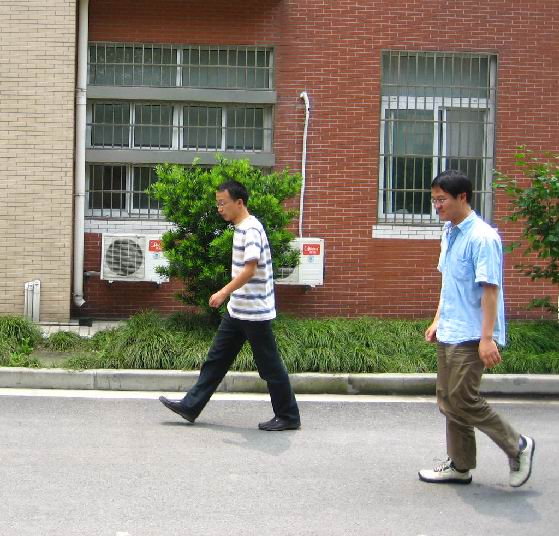

In [ ]:
# แสดงผลภาพออกมา
img = Image.open('PennFudanPed/PNGImages/FudanPed00001.png')
img

**1.6 แสดงผล Masks ที่ได้ทำการ Pre-labels ไว้**

number of pedestrian in image: 2


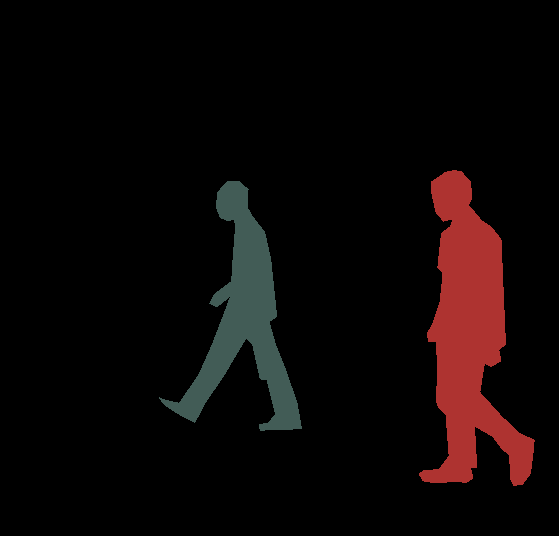

In [ ]:
mask = Image.open('PennFudanPed/PedMasks/FudanPed00001_mask.png')

mask_tensor = TF.ToTensor()(mask) # แปลงภาพ PIL เป็น Tensor

num_pedestrian = (len(torch.unique(mask_tensor)) -  1)   # ตรวจสอบจำนวนคนในภาพจากจำนวน Unique element 
print("number of pedestrian in image:",num_pedestrian)

rand_colors = torch.IntTensor([0,0,0])  # Initialize background เป็นสีดำ (RGB)

for i in range(num_pedestrian):
  one_rand_color =  (torch.floor(torch.rand(3)*255)).type(torch.int32) # สุ่มสี RGB เพื่อแสดงถึงคนแต่ละคนในภาพ
  rand_colors = torch.cat((rand_colors,one_rand_color))

mask.putpalette(rand_colors.tolist())  
mask

**1.7 เขียนฟังก์ชันโครงสร้าง Structure สำหรับเก็บข้อมูลภาพและข้อมูล labels**

ซึ่งฟังก์ชันดังกล่าวจะมี output ตรงกับ Input requirement ของโมเดล
โดย Class ที่ออกแบบจะเป็น child class ของ torch.utils.data.Dataset
และต้องมีการเขียน method len และ getitem เพิ่มเข้าไป

Method getitem จำเป็นต้องคืนค่าดังนี้ ( ตามเงื่อนไขของโมเดลที่เราต้องการเทรน )


1. image: Tensor ขนาด [C,H,W]


2. target: เป็น Dictionary ที่มีข้อมูลดังนี้
- **boxes** (FloatTensor[N, 4]): ตำแหน่งของกล่องในรูปแบบ [x0, y0, x1, y1] 
- **labels** (Int64Tensor[N]): labels บ่งบอกคลาส ในตัวอย่างนี้ 0 = background, 1 = pedestrian
- **image_id** (Int64Tensor[1]): ID ของภาพ (บ่งบอกความเป็น individual)
- **area** (Tensor[N]): ขนาด boundary box
- **iscrowd** (UInt8Tensor[N]): ตัวอย่างที่ตั้งค่านี้ไว้ iscrowd=True จะไม่ถูกประเมิณผล
- **masks** (UInt8Tensor[N, H, W]): ตำแหน่ง Pixel ที่ได้ segment labels ไว้สำหรับ pedestrian แต่ละคน

โดย C = Channel,   H = Height,   W = Width,   N = จำนวน Instance 

In [ ]:
# โครงสร้างข้อมูลนี้เป็น Sub-class ของ torch.utils.data.Dataset
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root):

        self.root = root
        #สร้าง List สำหรับเก็บค่า transformation
        transforms = []
        #แปลงภาพ PIL Image เป็น Torch.Tensor
        transforms.append(T.ToTensor())
        transforms = T.Compose(transforms)
        self.transforms = transforms
        
        #โหลดชื่อภาพมาเก็บไว้และจัดเรียงในโครงสร้าง List

        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages")))) 
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        
        #โหลดภาพและ masks จาก idx ที่ได้ระบุไว้จากโฟลเดอร์ PNGImages และ PedMasks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB") # เปิดภาพมาเก็บไว้ในตัวแปร img โดยเป็นภาพ 3 Channel
        mask = Image.open(mask_path)

        mask = np.array(mask)

        # ตรวจสอบ value ของ masks แต่ละคนในภาพ
        obj_ids = np.unique(mask)
        # ทำการตัด background ออกไป
        obj_ids = obj_ids[1:]

        # ทำการสร้าง masks ในรูปแบบ binary ขึ้นมา
        masks = mask == obj_ids[:, None, None]

        # ระบุตำแหน่งขอบของ boundary box จากข้อมูล masks ที่ได้ถูก labels ไว้
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        #สร้างโครงสร้าง Dictionary สำหรับส่งค่าออกจาก method
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        img, target = self.transforms(img, target) # transforms ภาพเป็น Tensor

        return img, target
      
    def __len__(self):
        return len(self.imgs)

**1.8 โหลดข้อมูลเข้าสู่ DATALoader สำหรับเตรียมพร้อมส่งเข้าเทรนในโมเดล**


In [ ]:
# โครงสร้างข้อมูลนี้เป็น Sub-class ของ torch.utils.data.Dataset
train_set_all = PennFudanDataset('PennFudanPed') # img เป็นภาพถูกส่งเข้าและถูกแปลงเป็น Tensor

batch_s = 2 # กำหนดขนาด Batch ในชุดข้อมูล Dataloader = 4 ภาพต่อ batch

train_ratio = 0.75 # กำหนดอัตราส่วนของ Train_ratio
split_point = int(len(train_set_all)*train_ratio)

torch.manual_seed(1)
indices = torch.randperm(len(train_set_all)).tolist()

train_set_split = torch.utils.data.Subset(train_set_all,indices[:split_point])
test_set_split  = torch.utils.data.Subset(train_set_all,indices[split_point:])

train_size = len(train_set_split)
test_size = len(test_set_split)

# Loader : โหลดข้อมูลเข้าสู่ torch.utils.data.Dataloader 
train_loader = torch.utils.data.DataLoader(train_set_split, batch_size=batch_s, shuffle=True, num_workers=4,collate_fn=utils.collate_fn)

test_loader = torch.utils.data.DataLoader(test_set_split, batch_size=batch_s, shuffle=False, num_workers=4,collate_fn=utils.collate_fn)

**1.9 ทดลองหยิบข้อมูลออกมาแสดงผล**

In [ ]:
batch = next(iter(train_loader)) # ทดลองหยิบ 1 batch ออกมาจาก train loader แล้วทำการแสดงผลข้อมูลภายใน
img,target = batch
print("Batch มีภาพจำนวน",len(img),"ภาพ")
one_img = img[0]
one_target = target[0]
print("ภาพมีขนาด", one_img.shape)
print(one_img)

Batch มีภาพจำนวน 2 ภาพ
ภาพมีขนาด torch.Size([3, 344, 460])
tensor([[[0.3137, 0.2863, 0.2824,  ..., 0.3412, 0.3569, 0.3647],
         [0.3255, 0.3098, 0.3098,  ..., 0.3647, 0.3686, 0.3608],
         [0.3451, 0.3412, 0.3451,  ..., 0.3490, 0.3569, 0.3569],
         ...,
         [0.2706, 0.2863, 0.2980,  ..., 0.5569, 0.5451, 0.5255],
         [0.2980, 0.2980, 0.2980,  ..., 0.4353, 0.4353, 0.4196],
         [0.3294, 0.3137, 0.3020,  ..., 0.3725, 0.3765, 0.3804]],

        [[0.3333, 0.3059, 0.3020,  ..., 0.3333, 0.3451, 0.3529],
         [0.3451, 0.3294, 0.3294,  ..., 0.3529, 0.3569, 0.3490],
         [0.3647, 0.3608, 0.3647,  ..., 0.3451, 0.3529, 0.3529],
         ...,
         [0.2902, 0.3059, 0.3176,  ..., 0.5412, 0.5216, 0.5059],
         [0.3176, 0.3176, 0.3176,  ..., 0.4275, 0.4157, 0.4118],
         [0.3490, 0.3333, 0.3216,  ..., 0.3647, 0.3686, 0.3725]],

        [[0.3098, 0.2824, 0.2784,  ..., 0.2510, 0.2784, 0.2863],
         [0.3216, 0.3059, 0.3059,  ..., 0.2784, 0.2902, 0.2824],

In [ ]:
print(one_target)

{'boxes': tensor([[292., 134., 446., 420.]]), 'labels': tensor([1]), 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8), 'image_id': tensor([2]), 'area': tensor([44044.]), 'iscrowd': tensor([0])}


จากโครงสร้าง Dataloader ดังกล่าว Dataset PennFudanPed ของเราจะพร้อมที่จะถูก feed เข้าสู่ model เพื่อทำการ training แล้ว ลำดับถัดไปจะเริ่มต้น Finetuning model

#Section ที่: 2 Finetuning the model
ในขั้นตอนนี้จะมีการใช้หลักการ Transfer learning เพื่อนำโมเดลที่ถูก Pre-trained ค่า weight เบื้องต้นไปแล้วมาทำการ Finetuning เพื่อปรับรูปแบบโมเดลให้สามารถทำนายข้อมูลตาม training set ที่เรามีได้

โมเดลที่จะนำมา Finetuning ในขั้นตอนนี้คือ Mask R-CNN ซึ่งถูกออกแบบ on top บน Faster R-CNN ซึ่งจะมีการทำงานควบคู่กันดังนี้
- Faster R-CNN จะทำนายตำแหน่ง Bounding box (Object detection) และ Class scores ของวัตถุในภาพ
- Mask R-CNN จะทำนาย Masks สำหรับวัตถุที่ต้องการ detect แต่ละชิ้น

**2.1 ในการเตรียมโมเดลเพื่อมาทำการ Finetuning มีขั้นตอนดังนี้**

2.1.1. Load model ที่ถูก Pre-trained ลงมาบนโปรแกรม

2.1.2  ระบุจำนวน Class ที่มีบน Dataset ที่จะนำมา Finetuning

2.1.3. แทนที่โครงสร้างข้อมูล Output บน classifier,detector ด้วยจำนวน Class ใหม่

In [ ]:
# ขั้นตอนที่ 2.1.1 Load model ที่ถูก Pre-trained มาแล้ว
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

# ขั้นตอนที่ 2.1.2 ระบุจำนวน Class ที่ต้องการทำนาย
num_classes = 2
# PennFudanPed ที่นำมาใช้มี 2 class คือ background และ pedestrain

# เก็บค่า input feature ของ box_predictor ออกมาจากโมเดล
in_features = model.roi_heads.box_predictor.cls_score.in_features
# เก็บค่า input feature ของ mask_classifier ออกมาจากโมเดล
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels

# ขั้นตอนที่ 2.1.3 แทนที่ Pre-trained head data classifier ด้วยจำนวน Class ใหม่
hidden_layer = 256
# แทนที่ box_predictor head ด้วย FastRCNN ที่มี num_class ที่ได้กำหนดใหม่เข้าไป
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
# แทนที่ mask_classifier head ด้วย MaskRCNN ที่มี numclass ที่ได้กำหนดใหม่เข้าไป
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,hidden_layer,num_classes)


Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


**2.2 เริ่มเทรนโมเดล**

Feed dataset ของเราเข้าไปในโมเดลเพื่อให้โมเดลทำการเรียนรู้ weight ที่ minimize loss โดยอาศัย dataset ตัวใหม่ที่ feed เข้าไป

In [ ]:
# ตั้งค่าอุปกรณ์ประมวลผล 
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') 
model.to(device)


params = [p for p in model.parameters() if p.requires_grad]
# ระบุ Optimizer ที่ต้องการใช้ (ในที่นี้ใช้ SGD)
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# ตั้งค่า Dynamic learning rate ซึ่งจะลดลงทุกๆ 3 epoch
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3, gamma=0.1)

# เริ่มเทรนโมเดล
for epoch in range(5):
    
    # Module ช่วยเทรนโดยช่วย Feedforward, loss, backpropogate, update weight รวมในคำสั่งเดียว
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    # Update ค่า learning rate
    lr_scheduler.step()

    # evaluate ผลลัพธ์ออกมาบนชุดข้อมูล test_loader
    evaluate(model, test_loader, device=device)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3000: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and uses scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Epoch: [0]  [ 0/64]  eta: 0:03:22  lr: 0.000084  loss: 4.6794 (4.6794)  loss_classifier: 0.8160 (0.8160)  loss_box_reg: 0.3362 (0.3362)  loss_mask: 3.4889 (3.4889)  loss_objectness: 0.0310 (0.0310)  loss_rpn_box_reg: 0.0074 (0.0074)  time: 3.1685  data: 0.2104  max mem: 2581
Epoch: [0]  [10/64]  eta: 0:01:32  lr: 0.000877  loss: 1.7386 (2.3634)  loss_classifier: 0.4987 (0.4862)  loss_box_reg: 0.2888 (0.2907)  loss_mask: 0.9099 (1.5485)  loss_objectness: 0.0232 (0.0314)  loss_rpn_box_reg: 0.0064 (0.0065)  time: 1.7042  data: 0.0280  max mem: 2856
Epoch: [0]  [20/64]  eta: 0:01:12  lr: 0.001670  loss: 0.9428 (1.6076)  loss_classifier: 0.2331 (0.3454)  loss_box_reg: 0.2279 (0.2487)  loss_mask: 0.4038 (0.9800)  loss_objectness: 0.0209 (0.0275)  loss_rpn_box_reg: 0.0042 (0.0060)  time: 1.5821  data: 0.0097  max mem: 2858
Epoch: [0]  [30/64]  eta: 0:00:55  lr: 0.002463  loss: 0.6970 (1.2673)  loss_classifier: 0.1433 (0.2725)  loss_box_reg: 0.1831 (0.2317)  loss_mask: 0.2521 (0.7341)  loss_ob

**2.3 ทดลอง Predict ผลลัพธ์ด้วยข้อมูลใน Test_loader**

In [ ]:
batch = next(iter(test_loader))
img,target = batch
test_img = img[1] 

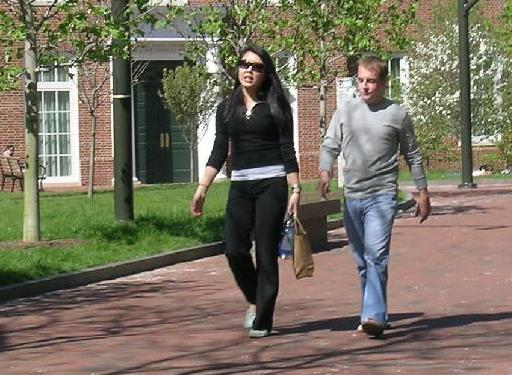

In [ ]:
# Visualize ภาพที่ต้องการทำนาย

test_img_PIL =  TF.ToPILImage(mode='RGB')(test_img) 
test_img_PIL

In [ ]:
# ปรับโมเดลเข้าสู่ Evaluation mode
model.eval() 

# ปิดฟังก์ชัน autograd engine เพื่อประหยัดทรัพยากรในการประมวลผล
with torch.no_grad():
  prediction = model([test_img.to(device)]) # ทำนายผลลัพธ์ออกมา

**2.4 ตรวจสอบค่าที่ได้จากการ Predict**

In [ ]:
# ข้อมูลจาก Object Prediction ประกอบด้วย Boxes,labels,masks,scores
num_people = len(prediction[0]['labels'])
location_of_people = prediction[0]['boxes']
labels = prediction[0]['labels']
scores = prediction[0]['scores']
masks = prediction[0]['masks']

# Class 1 หมายถึง คน และ Class 0 หมายถึง Background
print("จำนวนคนที่ตรวจสอบได้ในภาพมีจำนวน",num_people,"คน")

# แสดงผลตำแหน่งคนในรูปแบบ [x0,y0,x1,y1] 
for i in range(num_people):
  print("คนที่",i+1,"อยู่ที่ตำแหน่ง",location_of_people[i],"ค่า class:", labels[i].item(), "และค่า score",scores[i].item())

print("Masks เป็น Tensor ขนาด", masks.shape, "ซึ่งบ่งบอกตำแหน่ง Instance แต่ละคนที่ตรวจสอบเจอ") 


จำนวนคนที่ตรวจสอบได้ในภาพมีจำนวน 4 คน
คนที่ 1 อยู่ที่ตำแหน่ง tensor([1074.9315,  203.9775, 1240.4470,  687.6213], device='cuda:0') ค่า class: 1 และค่า score 0.9986201524734497
คนที่ 2 อยู่ที่ตำแหน่ง tensor([866.7258, 269.5800, 970.1111, 314.7073], device='cuda:0') ค่า class: 1 และค่า score 0.09476666897535324
คนที่ 3 อยู่ที่ตำแหน่ง tensor([212.6402, 269.3191, 352.6617, 338.2062], device='cuda:0') ค่า class: 1 และค่า score 0.07648292928934097
คนที่ 4 อยู่ที่ตำแหน่ง tensor([  8.3958, 262.3098, 203.5152, 699.6595], device='cuda:0') ค่า class: 1 และค่า score 0.057128340005874634
Masks เป็น Tensor ขนาด torch.Size([4, 1, 864, 1895]) ซึ่งบ่งบอกตำแหน่ง Instance แต่ละคนที่ตรวจสอบเจอ


# พบว่าค่าที่ predict มีดังนี้
- ตำแหน่งคนในรูปแบบกรอบพิกัด x,y ([x0,y0,x1,y1])
- Labels ของคลาสที่ predict ออกมา ในที่นี้ 1 แทนการ predict ว่าเป็นคน
- Scores ความน่าจะเป็นของ class
- Masks ซึ่งระบุตำแหน่งของคนแต่ละคนเป็น Segment

# Section ที่: 3 Image detection
**3.1 ทดลอง Visualize ผลลัพธ์โดยการวาด Boundary box ลงบนรูปภาพที่ทำการ Predict**

In [ ]:
# ฟังก์ชันสำหรับการวาดสี่เหลี่ยมลงบนภาพโดยอ้างอิงข้อมูลที่ได้จากการ Predict
def draw_rectangle_on_image(draw_img,prediction,width):

    draw = torch.tensor(draw_img) # สร้าง Copy 

    num_people = len(prediction[0]['labels'])
    location_of_people = prediction[0]['boxes']

    line_width = width
    half_width = int(line_width/2)

    for i in range(num_people):

       
        one_rand_color =  (torch.rand(3))
        R = one_rand_color[0].item()
        G = one_rand_color[1].item()
        B = one_rand_color[2].item()
        
        draw_location = location_of_people[i]
        x0 = int(draw_location[0].item())
        y0 = int(draw_location[1].item())
        x1 = int(draw_location[2].item())
        y1 = int(draw_location[3].item())

        #วาดเส้นแนวนอนขอบบน
        draw[0][y0-half_width:y0+half_width,x0-half_width:x1+half_width] = R
        draw[1][y0-half_width:y0+half_width,x0-half_width:x1+half_width] = G
        draw[2][y0-half_width:y0+half_width,x0-half_width:x1+half_width] = B

        #วาดเส้นแนวตั้งขอบขวา
        draw[0][y0:y1,x1-half_width:x1+half_width] = R
        draw[1][y0:y1,x1-half_width:x1+half_width] = G
        draw[2][y0:y1,x1-half_width:x1+half_width] = B

        #วาดเส้นแนวนอนขอบล่าง
        draw[0][y1-half_width:y1+half_width,x0-half_width:x1+half_width] = R
        draw[1][y1-half_width:y1+half_width,x0-half_width:x1+half_width] = G
        draw[2][y1-half_width:y1+half_width,x0-half_width:x1+half_width] = B

        #วาดเส้นแนวตั้งขอบซ้าย
        draw[0][y0:y1,x0-half_width:x0+half_width] = R
        draw[1][y0:y1,x0-half_width:x0+half_width] = G
        draw[2][y0:y1,x0-half_width:x0+half_width] = B

    return draw

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


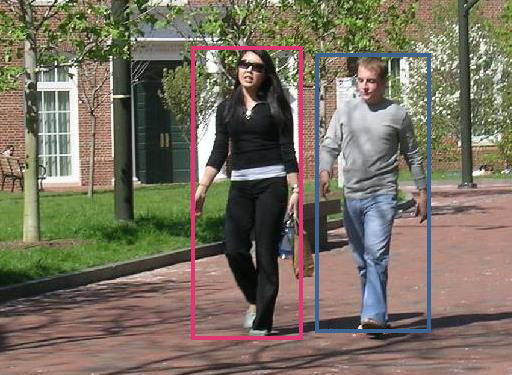

In [ ]:
# วาด boundary box ลงบนภาพ
draw_image = draw_rectangle_on_image(test_img,prediction,width=5)

# Visualize ภาพ
draw_PIL =  TF.ToPILImage(mode='RGB')(draw_image) 
draw_PIL

# Section ที่: 4 Instance image segmentation

**4.1 นำ Masks ที่ได้จากการ Predict ผ่าน Model มาประมวลผลและแสดงผลลัพธ์ออกมา**

In [ ]:
# ฟังก์ชันสำหรับสร้างภาพ Visualize masks ทุกๆ Instance ที่ Predict ได้ออกมา
def draw_masks_on_image(prediction):

  masks = prediction[0]['masks']
  total_masks = masks.shape[0]
  width = masks.shape[2]
  height = masks.shape[3]

  # เตรียม background สำหรับใส่ข้อมูลเข้าไป
  masks_color = torch.zeros([3,width,height]) 
  threshold = 100

  for i in range(total_masks):

    one_rand_color =  (torch.rand(3))
    R = one_rand_color[0].item()
    G = one_rand_color[1].item()
    B = one_rand_color[2].item()
    mask = (masks[i][0]*255 > threshold).cpu().data.numpy()
    results = np.where(mask == True) # index ตำแหน่งที่ต้องการ masks สีเข้าไป
    total_points = len(results[0])
    for i in range(total_points):
      x0,y0 = results[0][i],results[1][i]
      masks_color[0][x0][y0] = R
      masks_color[1][x0][y0] = G
      masks_color[2][x0][y0] = B
  return masks_color

In [ ]:
masks_color = draw_masks_on_image(prediction)

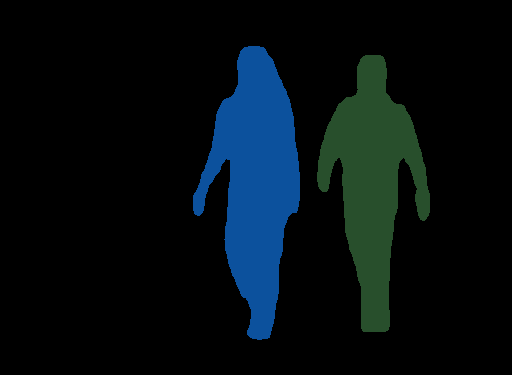

In [ ]:
mask_PIL =  TF.ToPILImage(mode='RGB')(masks_color) 
mask_PIL

# - - - - - - - - - - - - - - - - - - - - - - - - QUIZ - - - - - - - - - - - -- - - - - - - - - - - -

1. จงใช้โมเดลที่ได้ Finetuning มาข้างต้น Predict บนชุดข้อมูลชุดอื่นที่มีความแตกต่างจาก Training set แล้วสังเกตผลลัพธ์ดังนี้
- จำนวน Instance ที่ Predict ได้มีกี่จำนวน
- คะแนน Scores ของการ Predict แต่ละ Instance
- Visualize ผลลัพธ์ในรูปแบบ Boundary box บริเวณ Instance แต่ละ Instance ที่ detect พบ
- Visualize ผลลัพธ์ในรูปแบบ Masks

In [ ]:
# โหลดข้อมูลภาพชุดใหม่เข้ามา

%%shell
rm -r EX2_Testimage # delete if existing
git clone https://github.com/Kawee129/EX2_Testimage.git


Cloning into 'EX2_Testimage'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 9 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (9/9), done.


In [ ]:
# โหลดภาพเข้ามาในตัวแปร img
img_path = os.path.join("EX2_Testimage","test05.jpg")
img = Image.open(img_path).convert("RGB")

# แปลงภาพเป็น Tensor 
tensor_img = ???

# Predict ผลลัพธ์
model.eval()
with torch.no_grad():
    prediction = model([tensor_img.to(device)])

# Extract feature from prediction >> 
num_people =  ??
scores = ??
masks = ??

print("จำนวนคนที่ตรวจสอบได้ในภาพมีจำนวน",num_people)
for i in range(num_people):
  print("คนที่",i, "มีค่า score",scores[i].item())


# วาด boundary box ลงบนภาพ
draw_image = ?? # สามารถใช้ Function ช่วยที่ได้เขียนไว้ในตัวอย่างได้

# Visualize ภาพ
draw_PIL =  TF.ToPILImage(mode='RGB')(draw_image) 
draw_PIL


In [ ]:
# Visualize Masks
masks_color = ??  # สามารถใช้ Function ช่วยที่ได้เขียนไว้ในตัวอย่างได้
mask_PIL =  TF.ToPILImage(mode='RGB')(masks_color) 
mask_PIL

# - - - - - - - - - - - - - - - - - - - - - - - - เฉลย - - - - - - - - - - - -- - - - - - - - - - - -

จำนวนคนที่ตรวจสอบได้ในภาพมีจำนวน 4
คนที่ 1 อยู่ที่ตำแหน่ง tensor([1074.9315,  203.9775, 1240.4470,  687.6213], device='cuda:0') ค่า class: 1 และค่า score 0.9986201524734497
คนที่ 2 อยู่ที่ตำแหน่ง tensor([866.7258, 269.5800, 970.1111, 314.7073], device='cuda:0') ค่า class: 1 และค่า score 0.09476666897535324
คนที่ 3 อยู่ที่ตำแหน่ง tensor([212.6402, 269.3191, 352.6617, 338.2062], device='cuda:0') ค่า class: 1 และค่า score 0.07648292928934097
คนที่ 4 อยู่ที่ตำแหน่ง tensor([  8.3958, 262.3098, 203.5152, 699.6595], device='cuda:0') ค่า class: 1 และค่า score 0.057128340005874634


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  after removing the cwd from sys.path.


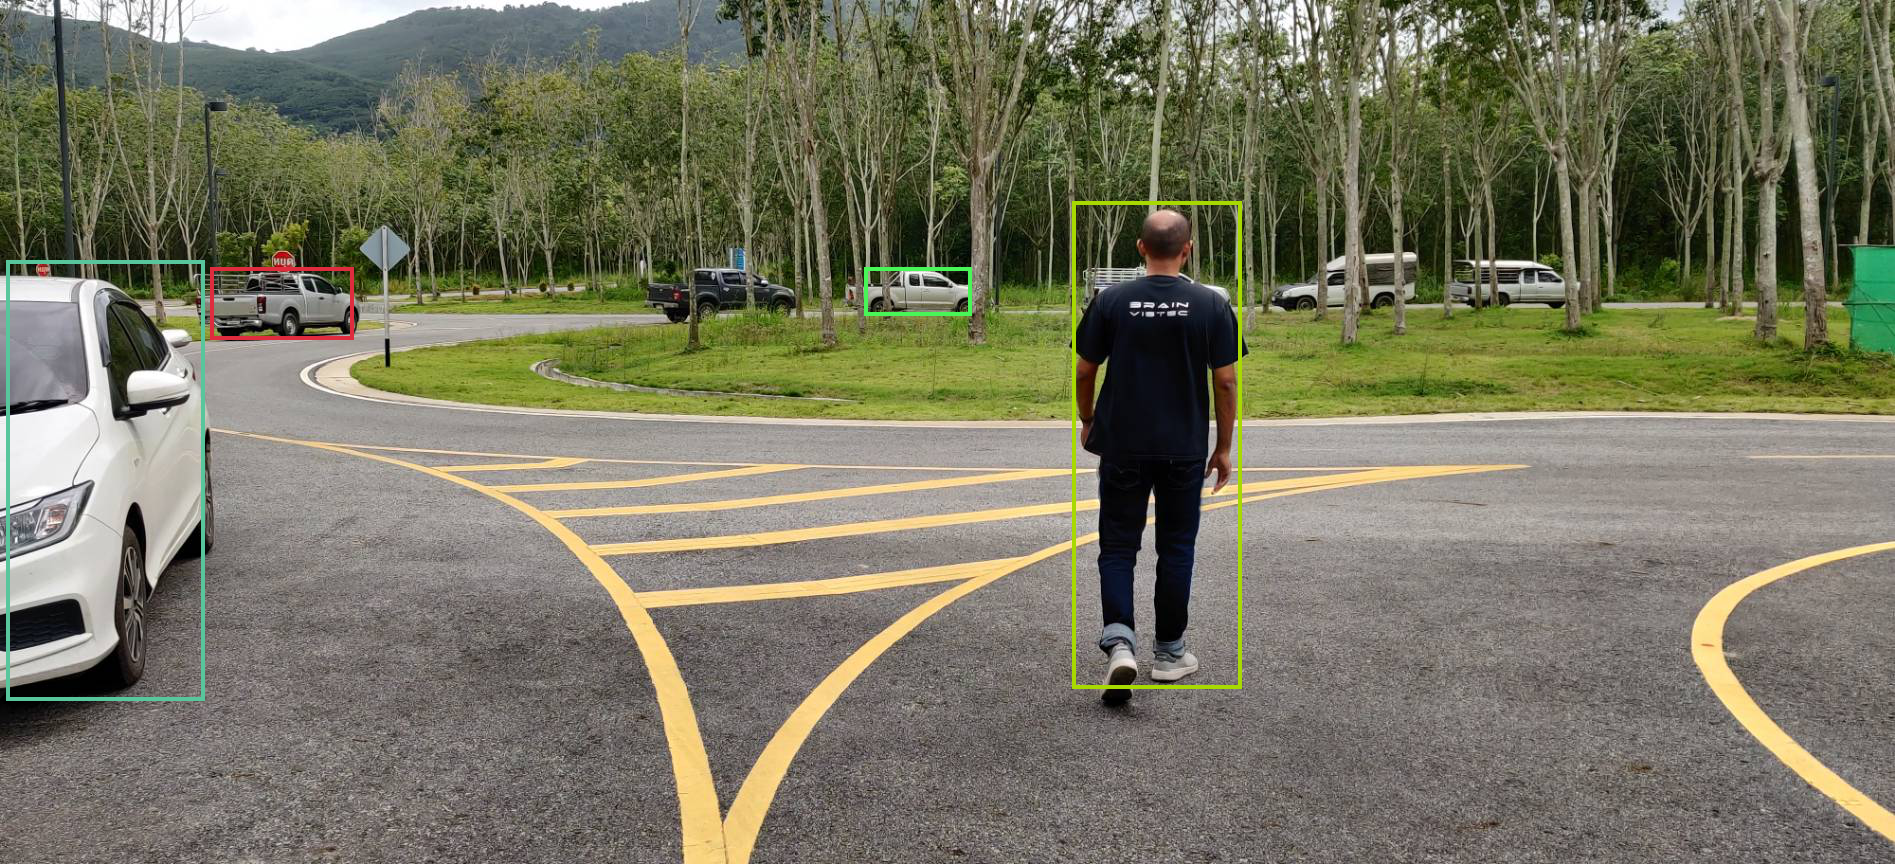

In [ ]:
# โหลดภาพเข้ามาในตัวแปร img
img_path = os.path.join("EX2_Testimage","test05.jpg")
img = Image.open(img_path).convert("RGB")

# แปลงเป็น Tensor 
tensor_img = TF.ToTensor()(img)

# Predict ผลลัพธ์
model.eval()
with torch.no_grad():
    prediction = model([tensor_img.to(device)])
  
num_people = len(prediction[0]['labels'])
location_of_people = prediction[0]['boxes']
labels = prediction[0]['labels']
scores = prediction[0]['scores']
masks = prediction[0]['masks']

print("จำนวนคนที่ตรวจสอบได้ในภาพมีจำนวน",num_people)
for i in range(num_people):
  print("คนที่",i+1,"อยู่ที่ตำแหน่ง",location_of_people[i],"ค่า class:", labels[i].item(), "และค่า score",scores[i].item())

# วาด boundary box ลงบนภาพ
draw_image = draw_rectangle_on_image(tensor_img,prediction,width=5)

# Visualize ภาพ
draw_PIL =  TF.ToPILImage(mode='RGB')(draw_image) 
draw_PIL


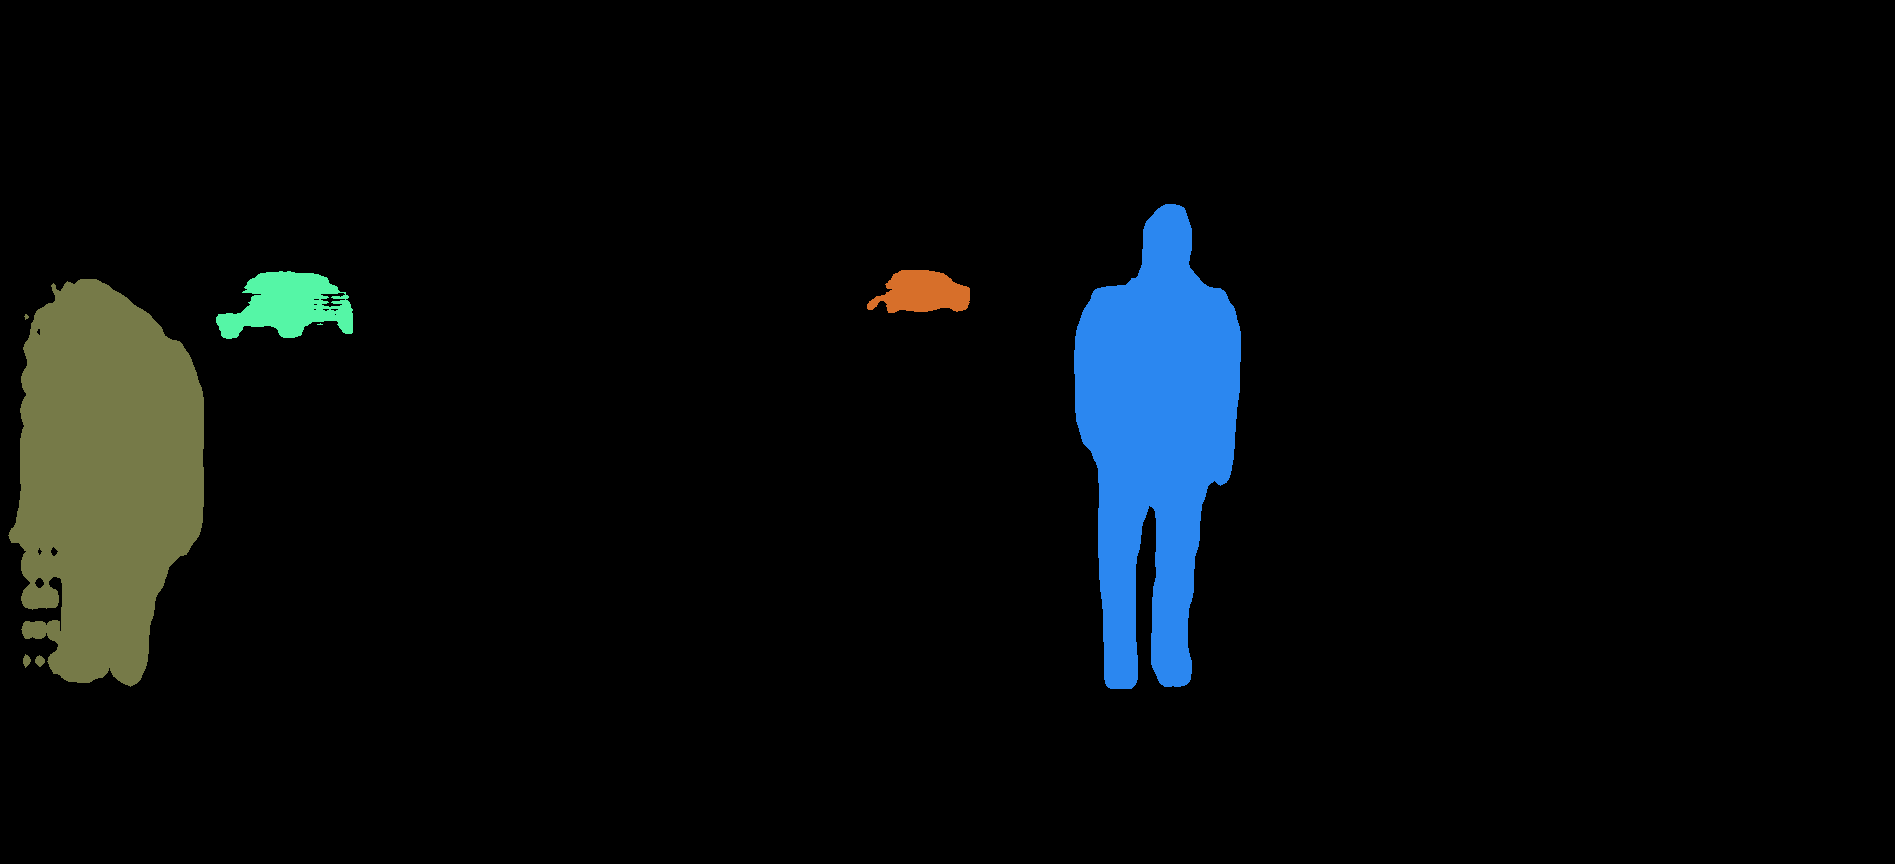

In [ ]:
# Visualize Masks
masks_color = draw_masks_on_image(prediction)
mask_PIL =  TF.ToPILImage(mode='RGB')(masks_color) 
mask_PIL

# สรุปผล
จากผลลัพธ์จะพบว่า ถ้าเราใช้ Dataset ชุดใหม่ที่มีวัตถุต่างๆที่แตกต่างไปจาก Dataset ที่เรานำมาเทรนโมเดล, ระบบมีโอกาสที่จะทำนายผิดพลาดได้สูงมาก
- ดังนั้นถ้าเราต้องการทำนายข้อมูลด้วย Dataset ของตัวเอง เราต้องทำชุดข้อมูลที่ประกอบด้วย Feature(ภาพ)และคู่ Labels ของสิ่งที่ต้องการทำนายและนำหลักการ Transfer learning มาทำการปรับ Model weight 
- ท้ายที่สุดเราจะได้ Weight ชุดใหม่ที่สามารถตรวจสอบ Feature ต่างๆของสิ่งที่เราสนใจได้ดียิ่งขึ้นนำไปสู่ผลลัพธ์ที่แม่นยำยิ่งขึ้น